In [1]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

/Users/colm/anaconda3/envs/xcrisp/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:

# indelphi sample
# >2_1_4_2_GTGTCGCCGGTCTACATTAC 30 FORWARD
# ATCGCTGAGCGTGTCGCCGGTCTACATTACAGGCTTCCCCCTGGGCTCGTAGCGC
def get_sequence_with_flank_lengths(sequence, pam_index, left_flank_len, right_flank_len, include_spacer=False):
    l = sequence[pam_index-left_flank_len:pam_index]
    r = sequence[pam_index:pam_index+right_flank_len]
    if include_spacer:
        return l + "|" + r
    else: 
        return l + r
sequence = "ATCGCTGAGCGTGTCGCCGGTCTACATTACAGGCTTCCCCCTGGGCTCGTAGCGC"
pam_index = 30
left_flank_len = 30
right_flank_len = 25
# print(f"Starting sequence: {sequence}")
after = get_sequence_with_flank_lengths(sequence, pam_index, left_flank_len, right_flank_len, include_spacer=True)
print(f"After sequence: {after}")

# FORECasT sample
# >Oligo_43170 42 FORWARD
# CTCCTATAATTCTAATCACTACAAGTCAGGAATGCCTGCGTTTGGCCGTCCAGTTAGTAACAGAAGGTCAGGTAAGAGG
sequence = "CTCCTATAATTCTAATCACTACAAGTCAGGAATGCCTGCGTTTGGCCGTCCAGTTAGTAACAGAAGGTCAGGTAAGAGG"
pam_index = 42
# print(f"Starting sequence: {sequence}")
after = get_sequence_with_flank_lengths(sequence, pam_index, left_flank_len, right_flank_len, include_spacer=True)
print(f"After sequence: {after}")





After sequence: ATCGCTGAGCGTGTCGCCGGTCTACATTAC|AGGCTTCCCCCTGGGCTCGTAGCGC
After sequence: TAATCACTACAAGTCAGGAATGCCTGCGTT|TGGCCGTCCAGTTAGTAACAGAAGG


In [3]:
from src.analysis.calculate_homology import read_fasta, smith_waterman_score

FORECAST_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/train.fasta'
FORECAST_test_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/train.fasta'
FC_sequences = read_fasta(FORECAST_train_file_path) + read_fasta(FORECAST_test_file_path)

print(f"Number of FORECasT Sequences: {len(FC_sequences)}")

Number of FORECasT Sequences: 13268


In [4]:
indelphi_test_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/inDelphi/train.fasta'
indelphi_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/inDelphi/test.fasta'
indelphi_sequences = read_fasta(indelphi_train_file_path) + read_fasta(indelphi_test_file_path)

print(f"Number of Indelphi Sequences: {len(indelphi_sequences)}")

Number of Indelphi Sequences: 1993


In [5]:
indelphi_sequences[0]

('2_1_4_2_GTGTCGCCGGTCTACATTAC',
 'GTCATATCGCTGAGCGTGTCGCCGGTCTACATTACAGGCTTCCCCCTGGGCTCGTAGCGC')

In [6]:
max_sw_score = smith_waterman_score(indelphi_sequences[0][1], indelphi_sequences[0][1])
print(f"Max Smith-Waterman Score is {max_sw_score}")

Max Smith-Waterman Score is 60.0


In [7]:
import pandas as pd

align_df = pd.read_csv("/Users/colm/repos/x-crisp/data/processed/alignment.tsv", sep="\t")
align_df = align_df.set_index("Target2")

In [8]:
# hack
align_df = align_df.drop('4_4_2_0_GCTTGGCTGTCTAATTATTT', axis=1)

In [9]:
target_ids = align_df.columns
FC_ids = [t for t in target_ids if "Oligo" in t]
indelphi_ids = [t for t in target_ids if "Oligo" not in t]

In [10]:
FC_alignment_scores = align_df[FC_ids].loc[FC_ids]
indelphi_alignment_scores = align_df[indelphi_ids]
cross_alignment_scores = align_df[indelphi_ids].loc[FC_ids]

Target2                 
Oligo_33090  Oligo_49283    37.0
             Oligo_26698    37.0
             Oligo_12523    36.0
             Oligo_6571     36.0
             Oligo_47864    39.0
dtype: float64
(61123096,)


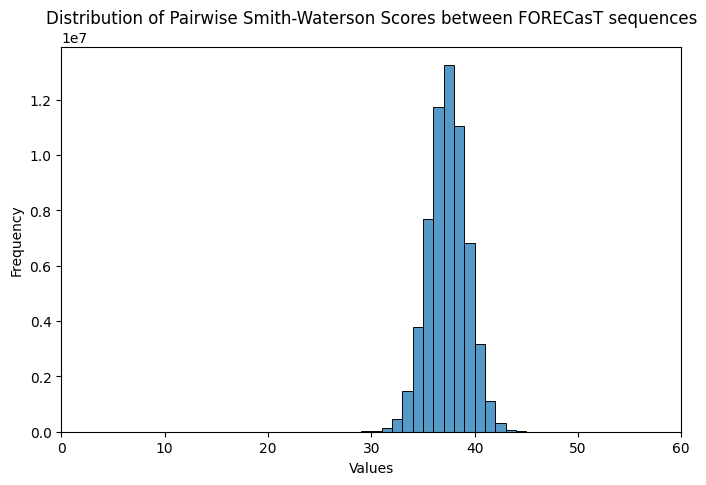

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Mask to get only the upper triangle (excluding the diagonal if desired)
import numpy as np
upper_triangle_values = FC_alignment_scores.where(np.triu(np.ones(FC_alignment_scores.shape), k=1).astype(bool)).stack()
print(upper_triangle_values.head())
print(upper_triangle_values.shape)

# Define the bin range and bin width (0 to 55 with bins of width 5)
bin_range = (0, 60)
bin_width = 1
bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values, bins=bins, kde=False)
plt.title('Distribution of Pairwise Smith-Waterson Scores between FORECasT sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig("./artifacts/pairwise-smith-waterson-forecast.pdf",  bbox_inches='tight')


Target2                                                   
2_4_2_2_CTTTCACAAGTAAGTATTCG  1_4_0_2_CTATGCCATTAAAAAAATTC    41.0
4_0_4_1_GCGTGGCTAACGCGGGGTAT  2_4_2_2_CTTTCACAAGTAAGTATTCG    39.0
                              1_4_0_2_CTATGCCATTAAAAAAATTC    35.0
0_4_4_2_GTCCTCCTGATACATTCGTT  4_0_4_1_GCGTGGCTAACGCGGGGTAT    38.0
                              2_4_2_2_CTTTCACAAGTAAGTATTCG    39.0
dtype: float64
(991020,)


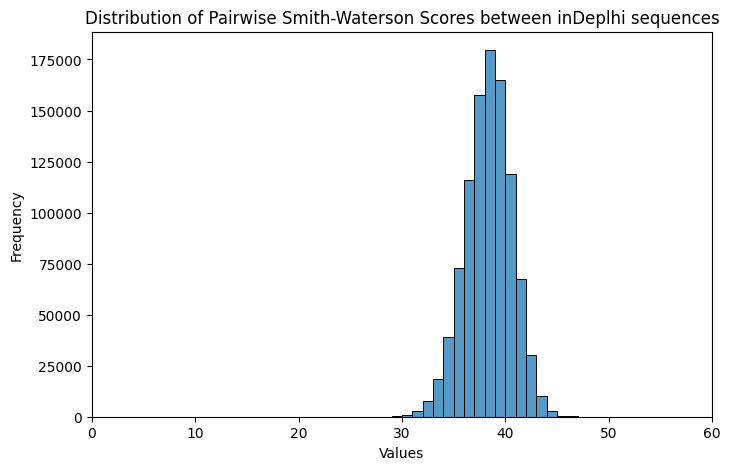

In [21]:
upper_triangle_values = indelphi_alignment_scores.where(np.triu(np.ones(indelphi_alignment_scores.shape), k=1).astype(bool)).stack()
print(upper_triangle_values.head())
print(upper_triangle_values.shape)


# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values, bins=bins, kde=False)
plt.title('Distribution of Pairwise Smith-Waterson Scores between inDeplhi sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig("./artifacts/pairwise-smith-waterson-indelphi.pdf",  bbox_inches='tight')


Target2                                  
Oligo_33090  0_3_1_1_TCACGACCATTCCTGATTAG    38.0
             2_2_4_2_ACGGTCCCTGTTCCAGCGTT    38.0
             1_2_3_3_TGCATTCTGAGTCAGGACCC    36.0
             0_3_2_3_TGATCCCCCACAATGTTGGG    36.0
             2_2_0_4_TTACCACTAAACATTGCAGC    37.0
dtype: float64
(1983036,)


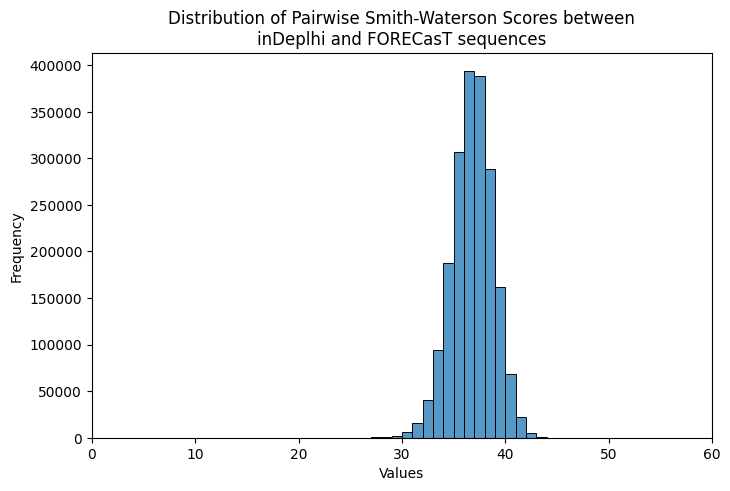

In [22]:
upper_triangle_values = cross_alignment_scores.where(np.triu(np.ones(cross_alignment_scores.shape), k=1).astype(bool)).stack()
print(upper_triangle_values.head())
print(upper_triangle_values.shape)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values, bins=bins, kde=False)
plt.title('Distribution of Pairwise Smith-Waterson Scores between\ninDeplhi and FORECasT sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig("./artifacts/pairwise-smith-waterson-pairwise.pdf",  bbox_inches='tight')

In [23]:
FORECAST_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/train.fasta'
FORECAST_test_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/FORECasT/test.fasta'
FC_train = read_fasta(FORECAST_train_file_path) 
FC_test = read_fasta(FORECAST_test_file_path)

print(f"Number of FORECasT Sequences: {len(FC_train)}")
print(f"Number of FORECasT Sequences: {len(FC_test)}")

Number of FORECasT Sequences: 6634
Number of FORECasT Sequences: 4424


In [24]:
indelphi_train_file_path = '/Users/colm/repos/repair-outcome-prediction/local/data/inDelphi/test.fasta'
indelphi_test = read_fasta(indelphi_test_file_path)

print(f"Number of Indelphi Sequences: {len(indelphi_test)}")

Number of Indelphi Sequences: 1593


In [25]:
FC_train = [f[0] for f in FC_train]
FC_test = [f[0] for f in FC_test]
indelphi_test = [i[0] for i in indelphi_test]

Target2                 
Oligo_10007  Oligo_10012    38.0
             Oligo_10018    37.0
             Oligo_1002     35.0
             Oligo_1003     36.0
             Oligo_10048    39.0
dtype: float64
(29342182,)


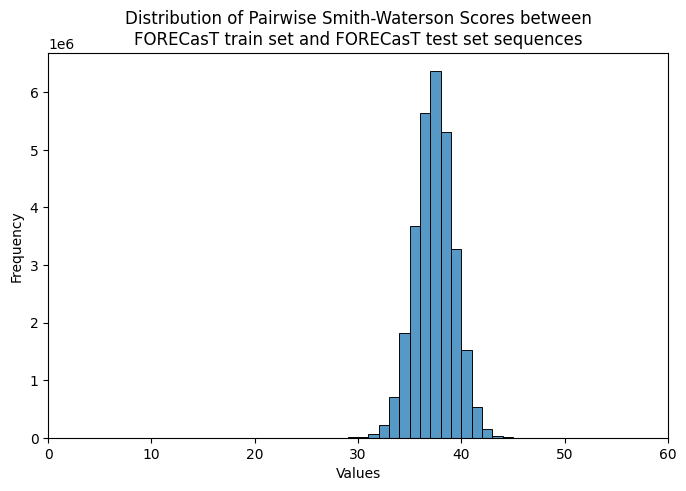

In [26]:
upper_triangle_values = FC_alignment_scores.loc[np.intersect1d(FC_test, FC_alignment_scores.columns.to_list()), np.intersect1d(FC_train, FC_alignment_scores.index.to_list())].stack()
print(upper_triangle_values.head())
print(upper_triangle_values.shape)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values, bins=bins, kde=False)
plt.title('Distribution of Pairwise Smith-Waterson Scores between\nFORECasT train set and FORECasT test set sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig("./artifacts/pairwise-smith-waterson-FC-train-FC-test.pdf",  bbox_inches='tight')

Target2                                  
Oligo_10012  0_0_0_0_AAATATCTTTAACCTAAAAC    35.0
             0_0_0_0_AATCCTCTAAATAGTTAAAT    37.0
             0_0_0_0_CTTTCACTTTATAGATTTAT    34.0
             0_0_0_1_TCTTATCTTGCAAGGCTTCA    35.0
             0_0_0_1_TGTCATCTTTATGCTTAAAG    37.0
dtype: float64
(10561328,)


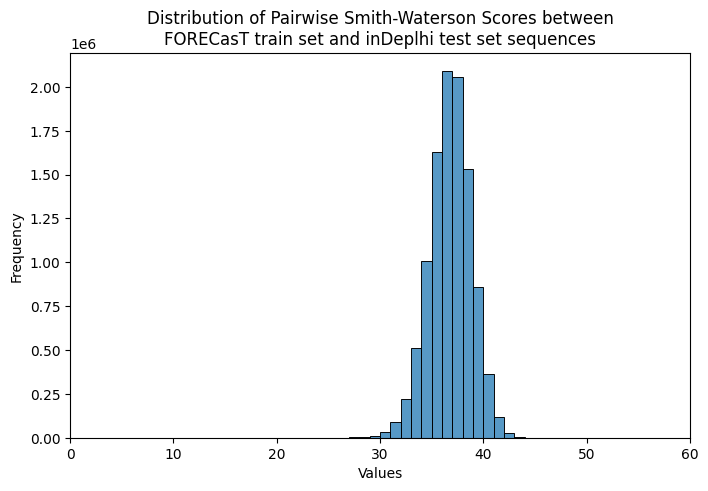

In [27]:
upper_triangle_values = cross_alignment_scores.loc[np.intersect1d(FC_train, cross_alignment_scores.index.to_list()), np.intersect1d(indelphi_test, cross_alignment_scores.columns.to_list())].stack()
print(upper_triangle_values.head())
print(upper_triangle_values.shape)

# Plot the distribution with specified bins and range
plt.figure(figsize=(8, 5))
sns.histplot(upper_triangle_values, bins=bins, kde=False)
plt.title('Distribution of Pairwise Smith-Waterson Scores between\nFORECasT train set and inDeplhi test set sequences')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(bin_range)  # Set x-axis limits to the specified range
plt.savefig("./artifacts/pairwise-smith-waterson-FC-train-indelphi-test.pdf",  bbox_inches='tight')

In [28]:
# sns.clustermap(FC_alignment_scores, 
#             vmin=0, vmax=55, 
#             metric="euclidean",        # Specifies Euclidean distance
#             method="ward",             # Specifies Ward clustering method
#             cmap="viridis",            # Color map for better visualization
#             standard_scale=1           # Normalizes each feature across rows
# )